In [14]:
import Pkg; Pkg.activate(".")

using Revise # for dev 
using DeconvMultiStep

using FITSIO

using Random
Random.seed!(1234)

include("plot_utils.jl")

  Activating project at `~/Desktop/En cours !/Simon/DeconvMultiStep/DeconvMultiStep.jl/notebooks`


plot_recon (generic function with 1 method)

## Make UV planes

# short bases: 7909
# long bases: 10280


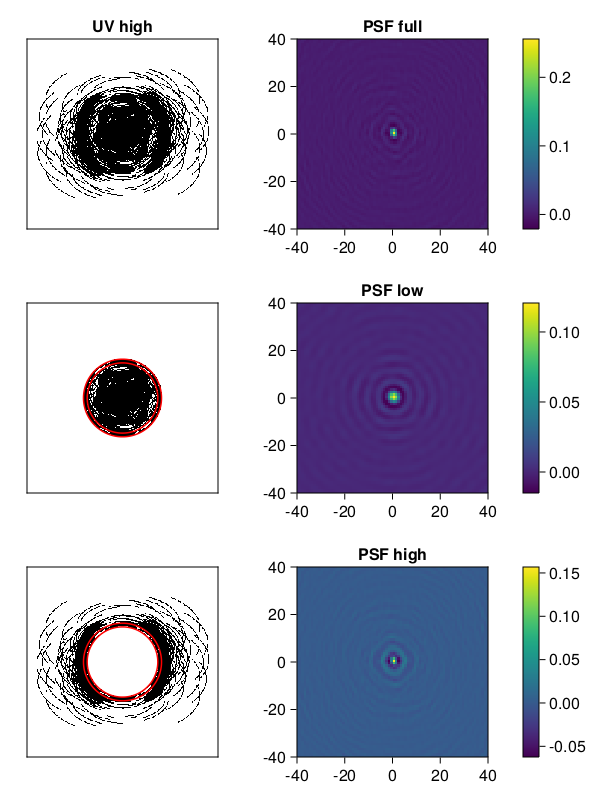

In [3]:
# sky file

sky = Float64.(read(FITS("Meerkat_Galactic_center_256.fits")[1]))
sky /= maximum(sky)
n_pix,  = size(sky)

# make all bases

bases = make_bases("uvgen-test.txt", n_pix)

# split bases and make psf's

ℓ = 50.0 # baseline center frequency (in pixels)
δ = 5.0  # baseline half width (in pixels)

psf, uv = make_psf(bases, n_pix, ℓ, δ) 
println("# short bases: $(sum(uv.low))")
println("# long bases: $(sum(uv.high))")

fig = plot_psf(psf, uv; zoom = 40)
#save("../../paper/figs/uv_psf.png", fig, px_per_unit = 4)

## Make dirty images

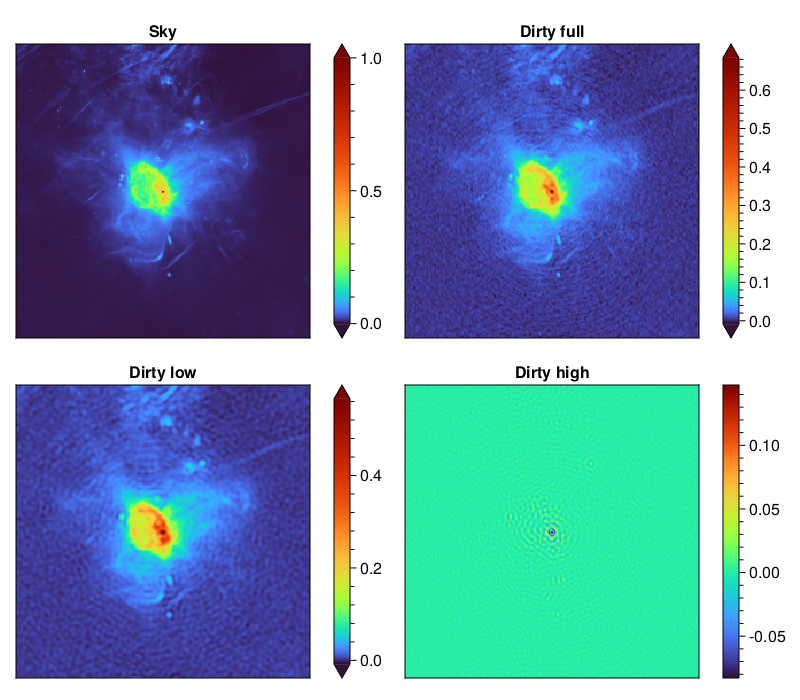

In [4]:
dirty = make_dirty(uv, sky, 1e-5)
fig = plot_dirty(dirty, sky)

## Deconv with all visibilities

In [8]:
η = compute_step(psf.full)
i_full, mse = fista(psf.full, dirty.full, 1e-4, 200, η; sky=sky, show_progress=true);

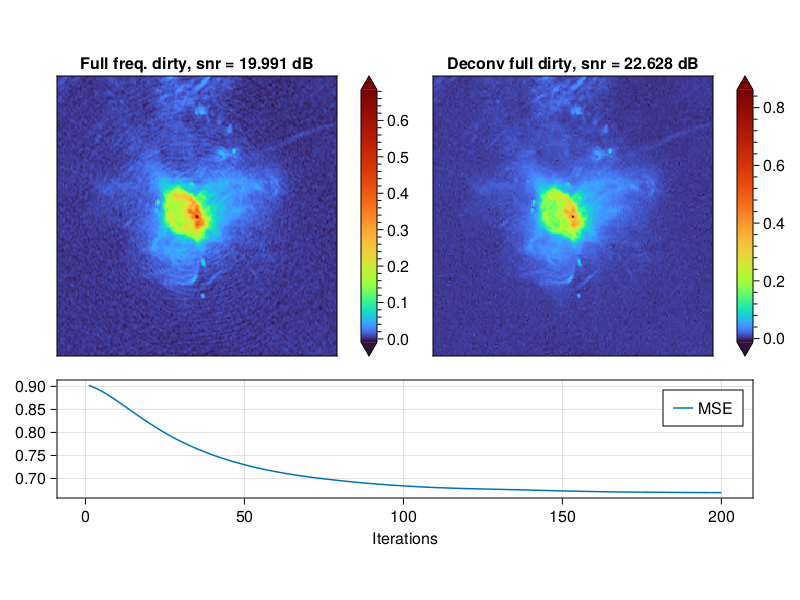

In [9]:
titles = ["Full freq. dirty, snr = $(snr(sky, dirty.full)) dB"
        "Deconv full dirty, snr = $(snr(sky, i_full)) dB"]
fig = plot_deconv(dirty.full, sky, i_full, mse, titles)
#save("../../paper/figs/recon_full.png", fig, px_per_unit = 4)

## Make filters

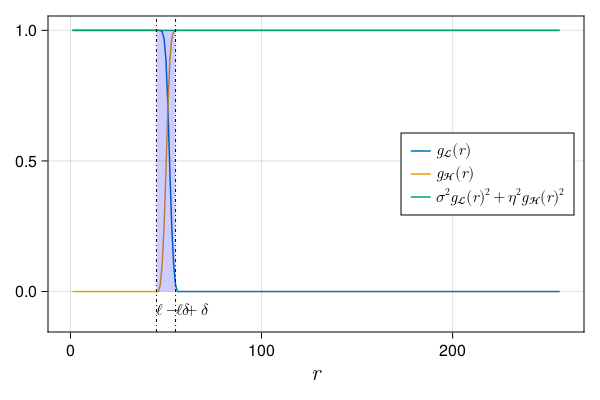

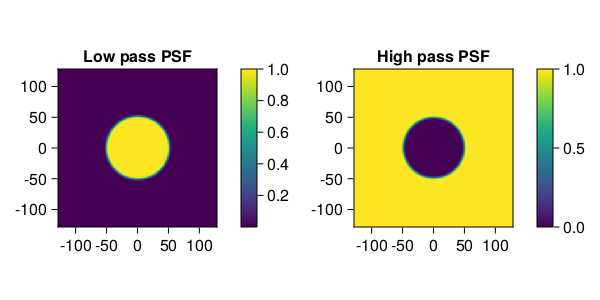

In [15]:
G = make_filters(ℓ, δ, n_pix)

fig_rad, fig_psf = plot_filters(ℓ, δ, n_pix; σ² = 1.0, η² = 1)
display(fig_rad)
display(fig_psf)

## Deconv with low frequencies

In [16]:
η = compute_step(psf.low)
i_low, mse = fista(psf.low, dirty.low, 1e-4, 100, η; sky=sky, show_progress=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


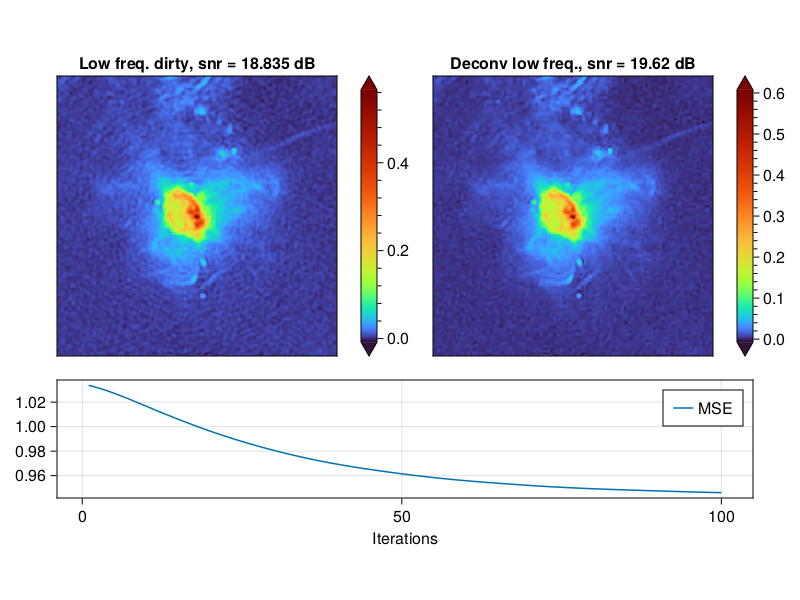

In [17]:
titles = ["Low freq. dirty, snr = $(snr(sky, dirty.low)) dB"
        "Deconv low freq., snr = $(snr(sky, i_low)) dB"]
fig = plot_deconv(dirty.low, sky, i_low, mse, titles)
#save("../../paper/figs/recon_low.png", fig, px_per_unit = 4)

## Add high frequencies

In [18]:
η = compute_step(psf.high; G=G)
i_multistep, mse = fista(psf.high, dirty.high, 1e-4, 100, η; G=G, ip = i_low, sky=sky, show_progress=true);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:05


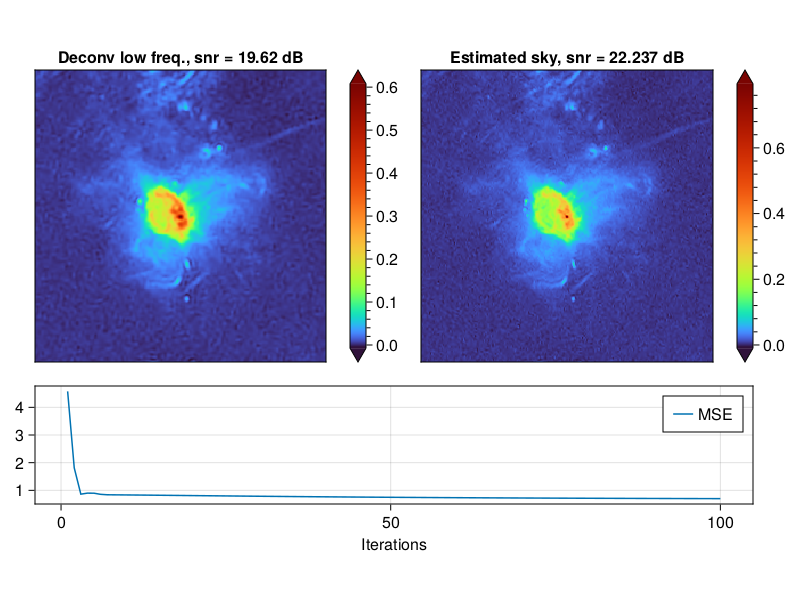

In [19]:
titles = ["Deconv low freq., snr = $(snr(sky, i_low)) dB", 
        "Estimated sky, snr = $(snr(sky, i_multistep)) dB"]
fig = plot_deconv(i_low, sky, i_multistep, mse, titles)

#save("../../paper/figs/recon_2steps.png", fig, px_per_unit = 4)

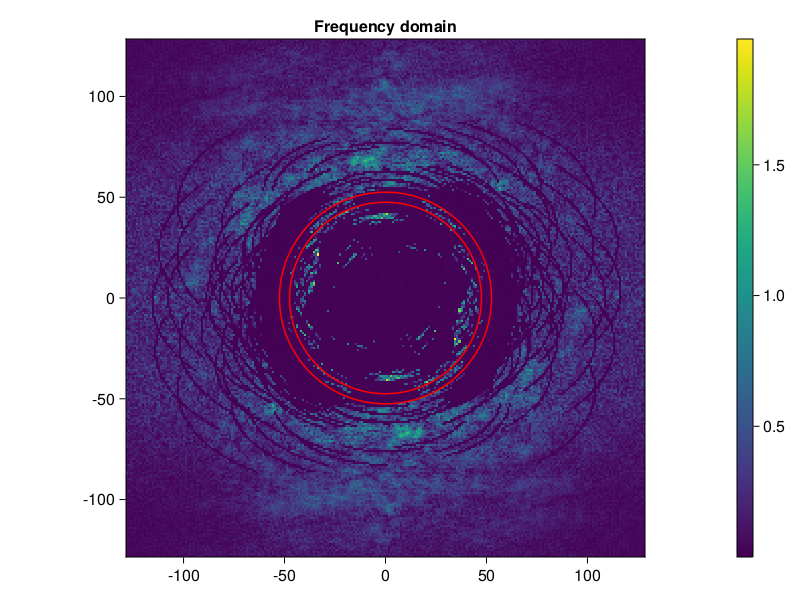

In [20]:
plot_recon(i_multistep - i_full, uv, ℓ, δ)